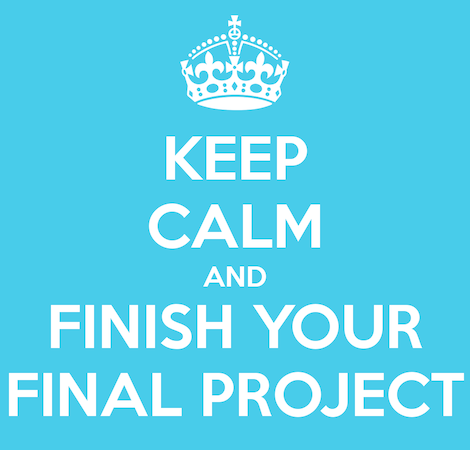

# Overview

<p style="line-height:1.75;font-size:16px">
It's time to put your skills to the test and take on a real-world data science project. You are given a dataset of ad impressions for Android users for a particular ad. Each line represents one impression for that ad and includes details such as timestamp, device, mobile carrier and more.
    
### Your task is to predict if a user will click or not on the ad.

<div style="line-height:1.75;background:#1e7b1e;padding-left:20px;padding-top:5px;padding-bottom:5px;border-radius:5px 5px 0px 0px"><i style="font-size:40px;color:#c1f0c1;">Solution Description</i>
   
</div>
<div>
<p style="line-height:1.75;font-size:16px;background:#c1f0c1;padding:20px;border-radius:0px 0px 5px 5px">
The solution is divided into few stages:<br>
1. <b>Learnning and Preperation</b> - Learnning the data, understanding each feature and its efect on the "click" column.<br>
2. <b>Data Normalization</b> - Some columns are meanless unless we divide them, classify them, or enrich them. For example
   <br><b>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;utc_time</b> - I choose to split it into is_weekend?, Month, Hour  and date
   <br><b>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;app_id</b> - I choose to enrich this data with Category and installs <br>
3. <b>Feature Selection</b> - I used "Pearson Correlation" and "Recursive Feature Elimination" - to check the influence of each column on "click" column.<br>
4. <b>Run the Classifiers</b> - I used "KNN", "DecisionTreeClassifier", "GradientBoostingClassifier", "RandomForestClassifier" also i used "GridSearchCV" and "optuna" to find the best params for the RandomForestClassifier model <br>
5. <b>Summarize and Conclusion</b><br>
</p>
<p style="line-height:1.75;font-size:16px;background:#c1f0c1;padding:20px;border-radius:0px 0px 5px 5px; color:hsla(0,100%,50%,1);">Important: I hold 3 types of DataFrame during the below book:<br> <strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;origin_data</strong> - the origin data without any manipulation<br><strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;normelized_data</strong> - data after normelize and enrichment<br><strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;samples</strong> - data that hold 10000 elements</p>

</div>



<div style="line-height:1.75;background:#3464a2;padding-left:20px;padding-top:5px;padding-bottom:5px;border-radius:5px 5px 0px 0px">
<i style="font-size:40px;color:#e6f1ff;">Phase 1:Learnning and Preperation</i>
</div>
<div>
<p style="line-height:1.75;background:#e6f1ff;padding:20px;border-radius:0px 0px 5px 5px">
    Read samples of 10000 rows, run some plots to understand the connection between columns to "click"
</p></div>

In [1]:
import pandas as pd
import numpy as np
import pytz
from datetime import datetime, timezone

states_tz = {
    'WA': 'US/Pacific',
    'OR': 'US/Pacific',
    'CA': 'US/Pacific',
    'NV': 'US/Pacific',
    'MT': 'US/Mountain',
    'ID': 'US/Mountain',
    'WY': 'US/Mountain',
    'UT': 'US/Mountain',
    'CO': 'US/Mountain',
    'NM': 'US/Mountain',
    'AZ': 'US/Mountain',
    'TX': 'US/Central',
    'OK': 'US/Central',
    'KS': 'US/Central',
    'MN': 'US/Central',
    'IA': 'US/Central',
    'MO': 'US/Central',
    'AR': 'US/Central',
    'LA': 'US/Central',
    'ND': 'US/Central',
    'SD': 'US/Central',
    'NE': 'US/Central',
    'WI': 'US/Central',
    'IL': 'US/Central',
    'MS': 'US/Central',
    'MI': 'US/Eastern',
    'VT': 'US/Eastern',
    'NH': 'US/Eastern',
    'ME': 'US/Eastern',
    'MA': 'US/Eastern',
    'RI': 'US/Eastern',
    'CT': 'US/Eastern',
    'OH': 'US/Eastern',
    'PA': 'US/Eastern',
    'NJ': 'US/Eastern',
    'KY': 'US/Eastern',
    'WV': 'US/Eastern',
    'MD': 'US/Eastern',
    'DE': 'US/Eastern',
    'VA': 'US/Eastern',
    'NC': 'US/Eastern',
    'SC': 'US/Eastern',
    'GA': 'US/Eastern',
    'NY': 'US/Eastern',
    'TN': 'US/Eastern',
    'IN': 'US/Eastern',
    'AL': 'US/Eastern',
    'FL': 'US/Eastern',
    'DC': 'US/Eastern',
    'HI': 'US/Hawaii',
    'AK': 'US/Alaska'
}

origin_data = pd.read_csv('data/android_bids_us.csv')
samples = origin_data.sample(10000)

origin_data.info()
origin_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3148828 entries, 0 to 3148827
Data columns (total 12 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   bidid          object
 1   utc_time       int64 
 2   app_id         object
 3   user_state     object
 4   user_isp       object
 5   device_maker   object
 6   device_model   object
 7   device_osv     object
 8   device_height  int64 
 9   device_width   int64 
 10  marketplace    object
 11  click          int64 
dtypes: int64(4), object(8)
memory usage: 288.3+ MB


,bidid,utc_time,app_id,user_state,user_isp,device_maker,device_model,device_osv,device_height,device_width,marketplace,click
0,87b0108c-6e9f-4783-8b80-8dd5aa3529a8,1536444331894,com.OppanaGames.CarSim,TX,AT&T Wireless,NaN,NaN,7.0,720,1280,chartboost,0
1,9284441f-a6ea-4698-9017-86436b92d416,1536444363932,com.mobilityware.CrownSolitaire,TX,T-Mobile USA,NaN,NaN,7.0,1280,720,chartboost,0
2,7e4779c2-f757-4324-8c2a-138b558b5a54,1536444386908,com.kuttigames.tenkyurollball,LA,AT&T Wireless,NaN,NaN,7.1.1,720,1280,chartboost,0
3,b64ea208-38ca-42ac-895e-0842d7352cc3,1536444405023,com.trendactionfree.call_of_sniper_duty_frontl...,TN,Comcast Cable,NaN,NaN,6.0.1,720,1280,chartboost,0
4,fd0c07cb-31f6-408c-9315-1cb652e76abc,1536444443458,com.landslab.my3rdgrademathgames,NC,AT&T U-verse,NaN,NaN,7.1.1,1024,768,chartboost,0


In [2]:
from ipywidgets import interact, interactive
import ipywidgets as widgets
import matplotlib.pyplot as plt
%matplotlib inline

@interact(ColumnName=samples.columns)
def create_plot(ColumnName='user_state'):
    
    click_true = samples[samples['click'] == True].groupby(ColumnName)[['click']].count()
    click_false = samples[samples['click'] == False].groupby(ColumnName)[['click']].count()
    
    if(len(click_true) > 500):
        print(f'Sorry cannot plot the following column to much values on axis x, column: "{ColumnName}"')
        return
    
    fig = plt.figure(figsize=(15,8))
    ax = fig.add_subplot(2, 1, 1)

    ax.bar(range(len(click_true)), click_true['click'], color='r', align='center')
    ax.bar(range(len(click_false)), click_false['click'], color='b', align='center')
    ax.set_xticklabels(click_true.index)
    
    
    
    ax.set_title(ColumnName)
    ax.set_ylabel('Click Count')
    ax.legend(['click_true', 'click_false'], loc='best')

    plt.show()


interactive(children=(Dropdown(description='ColumnName', index=3, options=('bidid', 'utc_time', 'app_id', 'use…

<div style="line-height:1.25;background:#f6e609;padding-left:20px;padding-top:5px;padding-bottom:5px;border-radius:5px 5px 0px 0px">
<i style="font-size: 30px;color:#ffffcc;">Conclusion</i>
</div>
<div>
<p style="line-height:1.75;font-size:16px;background:#ffffcc;padding:20px;border-radius:0px 0px 5px 5px">
From the operations of the plots (although we know that the sample does not strictly indicate the real data) we can see that: <strong>user_state, attributes related to the device (manufacturer, model) and attributes releate to the device dimension</strong> show high effect on the 'click' while other columns show less influence<br>
<strong>The check is the percent of the True click to the False Click, we are not interesting in the number of rows</strong>   </p></div>

<div style="line-height:1.75;background:#3464a2;padding-left:20px;padding-top:5px;padding-bottom:5px;border-radius:5px 5px 0px 0px">
<i style="font-size:40px;color:#e6f1ff;">Phase 2:Data Normelize</i>
</div>
<div>
<p style="line-height:1.75;background:#e6f1ff;padding:20px;border-radius:0px 0px 5px 5px">
    1. Convert timestamp into Month, Hour and is_weekend?<br>
    2. Enrich the app_id with category and number of users<br>
    3. Create a new file with name data/android_bids_us_date_normelize.csv that hold the normelize data
</p></div>

In [6]:
# Convert UTC to time and Date

# NO NEED TO RUN, FILE ALREADY EXIST

def convert_utc_time(r):
    tzone, timestamp = r.split('@')
    x = datetime.fromtimestamp(float(timestamp)/1000).replace(tzinfo=timezone.utc).astimezone(pytz.timezone(tzone)).timetuple()
    return list(x)[0:6]

# samples['TZ'] = samples.apply(lambda r: states_tz[r['user_state']] + '@' + str(r['utc_time']), axis=1)
# samples['year'], samples['month'] ,samples['date'],samples['hour'],samples['minute'],samples['sec']= zip(*samples['TZ'].map(convert_utc_time))

normelized_data['TZ'] = normelized_data.apply(lambda r: states_tz[r['user_state']] + '@' + str(r['utc_time']), axis=1)
normelized_data['year'],normelized_data['month'],normelized_data['date'],normelized_data['hour'],normelized_data['minute'],normelized_data['sec']= zip(*normelized_data['TZ'].map(convert_utc_time))

print("Done")



Done


In [7]:
import datetime

# Convert Date to is_weekend?

# NO NEED TO RUN, FILE ALREADY EXIST

def is_weekend(y, m, d):
    if ((datetime.datetime(y, m, d).weekday() + 2) < 5):  # Monday is 0 Sunday is 6 that's why i added 2
        return False
    else:
        return True
    
normelized_data['is_weekend'] = normelized_data.apply(lambda r: is_weekend(r['year'], r['month'], r['date']), axis=1)

normelized_data.drop(['utc_time'], axis=1, inplace=True)
normelized_data.drop(['TZ'], axis=1, inplace=True)
normelized_data.drop(['date'], axis=1, inplace=True)
normelized_data.drop(['year'], axis=1, inplace=True)
normelized_data.drop(['minute'], axis=1, inplace=True)
normelized_data.drop(['sec'], axis=1, inplace=True)

normelized_data.info()
normelized_data.head()

print("Done")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3148828 entries, 0 to 3148827
Data columns (total 14 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   bidid          object
 1   app_id         object
 2   user_state     object
 3   user_isp       object
 4   device_maker   object
 5   device_model   object
 6   device_osv     object
 7   device_height  int64 
 8   device_width   int64 
 9   marketplace    object
 10  click          int64 
 11  month          int32 
 12  hour           int32 
 13  is_weekend     bool  
dtypes: bool(1), int32(2), int64(3), object(8)
memory usage: 291.3+ MB
Done


# Enrich the data using play_apps.zip

In [8]:

# NO NEED TO RUN, FILES ALREADY EXIST

from zipfile import ZipFile
from tqdm import tqdm
from os import path
import pickle

def build_apps_df():
    
    with ZipFile("data/play_apps.zip", 'r') as zip:
        apps = zip.namelist()
        print("num of files in zip: " + str(len(apps)))

        apps_df = pd.DataFrame()
        for app in tqdm(apps):
            app = pickle.loads(zip.read(app))
            apps_df = pd.concat([apps_df, pd.DataFrame.from_dict(app, orient="index").transpose()])
            
        # Saving and loading data into bucket
        apps_df.to_csv("data/apps_df.csv")
        
build_apps_df()

  0%|▎                                                                            | 111/29463 [00:00<00:51, 564.58it/s]

num of files in zip: 29463


100%|████████████████████████████████████████████████████████████████████████████| 29463/29463 [05:27<00:00, 90.03it/s]


In [9]:
apps_df = pd.read_csv("data/apps_df.csv")
print(apps_df.shape)
apps_df.sample(5)

(29463, 32)


,Unnamed: 0,title,icon,screenshots,video,category,score,histogram,reviews,description,...,content_rating,iap_range,interactive_elements,developer,developer_email,developer_url,developer_address,app_id,url,bids
5010,0,777Classic Vegas Slots-2500000 Free Coins Ever...,https://lh3.googleusercontent.com/eE2Hrw7-ZLZ-...,['https://lh3.googleusercontent.com/JW-r9F8S45...,NaN,['GAME_CASINO'],4.5,"{5: 166, 4: 15, 3: 16, 2: 3, 1: 14}",214,Reward 2500000 free coins every day！It's free ...,...,"['Teen', 'Simulated Gambling']","('$1.99', '$99.99')",NaN,Globe Grape Game(Slots Teen patti Casino),ggg@putaoyouxi.com,http://www.coconuttec.com/,"FLAT/RM C 21/F, CENTRAL 88, 88 DES VOEUX ROAD ...",com.coconuttec.slots.classic,https://play.google.com/store/apps/details?id=...,929
29421,0,Abyss — Thrilling Chat Stories,https://lh3.googleusercontent.com/baPMPurtVcZe...,['https://lh3.googleusercontent.com/BjLGm0DLl6...,NaN,['BOOKS_AND_REFERENCE'],4.5,"{5: 10591, 4: 1208, 3: 538, 2: 254, 1: 785}",13376,In the Abyss app you will find dozens of breat...,...,"['Teen', 'Violence, Blood, Sexual Themes, Drug...","('$0.99', '$64.99')","['Users Interact, Digital Purchases']","OOO ""Kupi baton""",help.vzahleb@gmail.com,http://telegra.ph/Abyss-Mobile-App-Privacy-Pol...,"Narimanov ave. 1, building 3, office 208, Ulya...",zahleb.me,https://play.google.com/store/apps/details?id=...,1503
20289,0,FPS Gun Camera 3D,https://lh3.googleusercontent.com/kbULwM29dR9r...,['https://lh3.googleusercontent.com/z6izBxqdd6...,NaN,['GAME_SIMULATION'],4.4,"{5: 2987, 4: 497, 3: 237, 2: 71, 1: 274}",4066,With this real 3D gun camera you will have ton...,...,"['Teen', 'Violence, Blood']",NaN,NaN,Jadynut Games,targetshootinggames@gmail.com,http://www.targetshootinggames.com/,NaN,com.targetshootinggame.fpsguncam3d,https://play.google.com/store/apps/details?id=...,74
3798,0,Idle Tycoon: Space Company,https://lh3.googleusercontent.com/x4jeZ7ucfdNh...,['https://lh3.googleusercontent.com/AF6SGrYDqx...,NaN,['GAME_SIMULATION'],NaN,{},0,"Manage the Idle Space Company, a leading joint...",...,['Everyone'],"('$0.99', '$99.99')",['Digital Purchases'],Bling Bling Games GmbH,support@blingblinggames.com,http://idlespacecompany.com/isc_privacy.html,Bling Bling Games GmbH\nKaiserstr. 129\n76133 ...,com.blingblinggames.idlespacecompany,https://play.google.com/store/apps/details?id=...,45
23795,0,Video & TV Cast | Roku Remote & Movie Stream App,https://lh3.googleusercontent.com/gmXW6q9L64K9...,['https://lh3.googleusercontent.com/B2L6TKcBW_...,NaN,['ENTERTAINMENT'],4.0,"{5: 2200, 4: 591, 3: 199, 2: 106, 1: 649}",3745,"Upgrade your Roku Stick, Roku Box and Roku TV ...",...,['Everyone'],"('$1.49', '$4.99')",['Digital Purchases'],2kit consulting,info@video-tv-cast.com,http://video-tv-cast.com/roku,Kraus und Karnath GbR\nGraf-Adolf-Straße 41\n4...,de.twokit.video.tv.cast.browser.roku,https://play.google.com/store/apps/details?id=...,2204


In [10]:
apps_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29463 entries, 0 to 29462
Data columns (total 32 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                29463 non-null  int64  
 1   title                     29463 non-null  object 
 2   icon                      29463 non-null  object 
 3   screenshots               29463 non-null  object 
 4   video                     9150 non-null   object 
 5   category                  29463 non-null  object 
 6   score                     29351 non-null  float64
 7   histogram                 29463 non-null  object 
 8   reviews                   29463 non-null  int64  
 9   description               29463 non-null  object 
 10  description_html          29463 non-null  object 
 11  recent_changes            10518 non-null  object 
 12  editors_choice            29463 non-null  bool   
 13  price                     28312 non-null  object 
 14  free  

In [11]:
apps_df["category"].value_counts()

['GAME_SIMULATION']                        2637
['GAME_PUZZLE']                            2351
['GAME_ACTION']                            2277
['GAME_CASUAL']                            1873
['ENTERTAINMENT']                          1831
                                           ... 
['GAME_SPORTS', 'FAMILY_PRETEND']             1
['GAME_RACING', 'FAMILY_CREATE']              1
['GAME_BOARD', 'FAMILY_CREATE']               1
['FOOD_AND_DRINK', 'FAMILY_BRAINGAMES']       1
['GAME_TRIVIA', 'FAMILY_EDUCATION']           1
Name: category, Length: 129, dtype: int64

In [12]:
apps_df["installs"].value_counts()

100,000+          6960
1,000,000+        6231
10,000+           4018
500,000+          3209
50,000+           2468
10,000,000+       1821
5,000,000+        1708
1,000+            1243
5,000+            1103
50,000,000+        236
500+               171
100,000,000+       151
100+               105
500,000,000+        15
10+                 10
50+                  5
1,000,000,000+       3
5+                   2
1+                   2
0+                   1
Name: installs, dtype: int64

In [13]:
def fill_category(app_id, col):
    val = apps_df[apps_df["app_id"] == app_id][col]
    return val.tolist()

In [14]:
from tqdm import tqdm

tqdm.pandas()
normelized_data["app_category"] = normelized_data.progress_apply(lambda row: fill_category(row["app_id"], "category"), axis=1)
normelized_data["app_installs"] = normelized_data.progress_apply(lambda row: fill_category(row["app_id"], "installs"), axis=1)
# test_df

C:\Users\user\anaconda3\lib\site-packages\tqdm\std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|█████████████████████████████████████████████████████████████████████| 3148828/3148828 [1:20:55<00:00, 648.48it/s]


# save data/android_bids_us_date_normelize.csv

In [8]:
# Store the new file
normelized_data.to_csv ('data/android_bids_us_date_normelize.csv', index = False, header=True)

print("Done")

Done


In [5]:
normelized_data = pd.read_csv('data/android_bids_us_date_normelize.csv')

print(normelized_data.describe())
print(normelized_data.info())
print("Done")

       device_height  device_width         click         month          hour
count   3.148828e+06  3.148828e+06  3.148828e+06  3.148828e+06  3.148828e+06
mean    1.180970e+03  1.152078e+03  6.770741e-02  9.501091e+00  1.283085e+01
std     5.190901e+02  4.526602e+02  2.512432e-01  9.406265e-01  6.899052e+00
min     1.400000e+01  1.400000e+01  0.000000e+00  8.000000e+00  0.000000e+00
25%     7.200000e+02  7.200000e+02  0.000000e+00  9.000000e+00  7.000000e+00
50%     1.080000e+03  1.080000e+03  0.000000e+00  1.000000e+01  1.400000e+01
75%     1.280000e+03  1.280000e+03  0.000000e+00  1.000000e+01  1.900000e+01
max     3.120000e+03  3.120000e+03  1.000000e+00  1.100000e+01  2.300000e+01
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3148828 entries, 0 to 3148827
Data columns (total 16 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   bidid          object
 1   app_id         object
 2   user_state     object
 3   user_isp       object
 4   device_maker   object
 5   

In [7]:
normelized_data.size

50381248

##  Plot on "weekend" and "hour" to understand the data

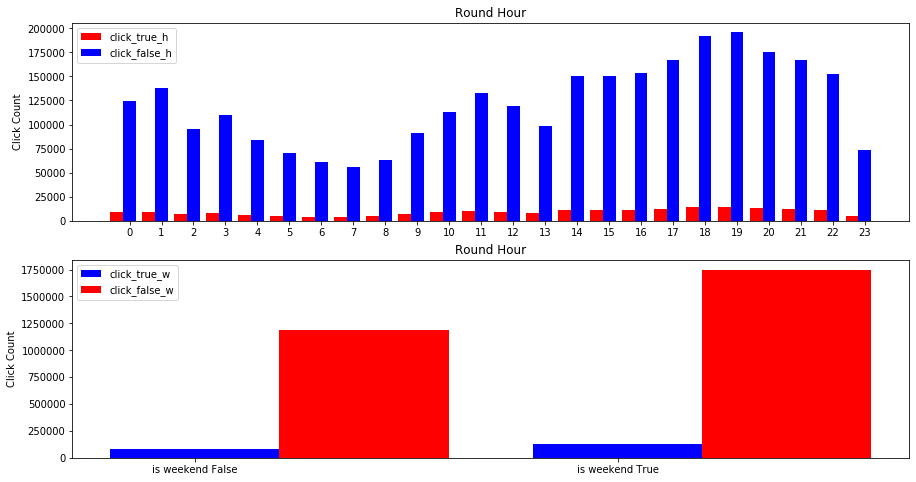

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

click_true_h = normelized_data[normelized_data['click'] == True].groupby('hour')[['click']].count()
click_false_h = normelized_data[normelized_data['click'] == False].groupby('hour')[['click']].count()

fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(2, 1, 1)
ax1.bar(x=click_true_h.index-0.4, width=0.4, height=click_true_h['click'], color='r',
        align='center',
        tick_label=[f'{c}' for c in click_true_h.index])
ax1.bar(x=click_false_h.index, width=0.4, height=click_false_h['click'], color='b',
        align='center',
        tick_label=[f'{c}' for c in click_false_h.index])
ax1.set_title('Round Hour')
ax1.set_ylabel('Click Count')
ax1.legend(['click_true_h', 'click_false_h'], loc='best')

click_true_w = normelized_data[normelized_data['click'] == True].groupby('is_weekend')[['click']].count()
click_false_w = normelized_data[normelized_data['click'] == False].groupby('is_weekend')[['click']].count()

ax2 = fig.add_subplot(2, 1, 2)
ax2.bar(x=click_true_w.index-0.4, width=0.4, height=click_true_w['click'], color='b',
        align='center',
        tick_label=[f'is weekend {c}' for c in click_true_w.index])
ax2.bar(x=click_true_w.index, width=0.4, height=click_false_w['click'], color='r')
ax2.set_title('Round Hour')
ax2.set_ylabel('Click Count')
ax2.legend(['click_true_w', 'click_false_w'], loc='best')

plt.show()

<div style="line-height:1.25;background:#f6e609;padding-left:20px;padding-top:5px;padding-bottom:5px;border-radius:5px 5px 0px 0px">
<i style="font-size: 30px;color:#ffffcc;">Conclusion</i>
</div>
<div>
<p style="line-height:1.75;font-size:16px;background:#ffffcc;padding:20px;border-radius:0px 0px 5px 5px">
The rate between "click" and "not click" it does not changed per hour or per weekday or weekend, so not so sure if this params improve prediction</p></div>


<div style="line-height:1.75;background:#3464a2;padding-left:20px;padding-top:5px;padding-bottom:5px;border-radius:5px 5px 0px 0px">
<i style="font-size:40px;color:#e6f1ff;">Phase 3:Feature selection</i>
</div>
<div>
<p style="line-height:1.75;background:#e6f1ff;padding:20px;border-radius:0px 0px 5px 5px">
    I used "Pearson Correlation" and "Recursive Feature Elimination" - to check the influence of each column on "click" column.
</p></div>

In [10]:
samples = normelized_data.sample(10000)

### Pearson  Correlation
<br>
<h3>
$r=\frac{\sum(x-\bar{x})(y-\bar{y})}{\sqrt{\sum(x-\bar{x})^2\sum(y-\bar{y})^2}}$
</h3>
<p style="line-height:1.75;font-size:16px">
We'll check the absolute value of the Pearson’s correlation between the target and each numerical feature in our dataset and keep the top n features based on this criterion.

In [11]:

### Warnning running on the real data is too long, and cause some erro : Cannot convert non-finite values (NA or inf) to integer
### Running on Samples - 10000 rows

MAX_FEATURES = 30

num_cols = ['click', 'device_height','device_width', 'hour', 'is_weekend']
cat_cols = ['user_isp','device_maker','device_model','device_osv']

data_for_pearson = pd.concat([samples[num_cols], pd.get_dummies(samples[cat_cols])], axis=1)

print(f'size of data before dropna {data_for_pearson.size}')
data_for_pearson = data_for_pearson.dropna()
print(f'size of data after dropna {data_for_pearson.size}')

y = data_for_pearson['click']
X = data_for_pearson.drop('click', axis=1)

print("Done")
print()
print(f'Number of columns after "get_dummies" {data_for_pearson.columns.size}')

size of data before dropna 9150000
size of data after dropna 9150000
Done

Number of columns after "get_dummies" 915


In [12]:
import numpy as np

def correlation_selector(X, y, features_num):
    correlations = []
    feature_names = X.columns

    for i in feature_names:
        correlation = np.corrcoef(X[i], y)[0, 1]
        correlations.append(correlation)
    
    # replace NaN with 0
    correlations = [0 if np.isnan(correlation) else correlation for correlation in correlations]
    feature_correlations = list(zip(feature_names, correlations))
    feature_correlations = sorted(feature_correlations, key=lambda x: np.abs(x[1]), reverse=True)
    return feature_correlations[:MAX_FEATURES]
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature
results = correlation_selector(X, y,MAX_FEATURES)

for r in results:
    print(f'{r[0]: <20} {r[1]:.3f}')

device_width         -0.066
device_maker_LG      0.052
device_maker_Kakatech 0.038
device_model_K88     0.038
device_model_Pixel 2 XL 0.038
user_isp_Manti Tele Communication Company 0.037
device_model_Studio MEGA 0.037
device_model_WAS-LX1A 0.037
user_isp_Montana State University 0.037
device_model_HTC6525LVW 0.037
user_isp_Jackson Energy Authority 0.037
user_isp_Chickasaw Telephone 0.037
user_isp_InfoWest    0.037
user_isp_Net-Change.Com 0.037
device_model_SM-N910C 0.037
user_isp_Cellcom     0.037
user_isp_Medicine Park Telephone Company 0.037
device_model_F3113   0.037
user_isp_VTX Communications 0.037
device_model_US991   0.037
device_model_KOB-W09 0.037
user_isp_Infostructure Cable and Internet 0.037
user_isp_Clearwave Communications 0.037
user_isp_Iowa Communications Network 0.037
user_isp_Golden West Telecommunications Coop. 0.037
user_isp_Hosting Services Inc 0.037
device_model_5056E   0.037
device_osv_8.0.0     -0.035
device_maker_Google  0.035
device_model_K009    0.034


### Recursive Feature Elimination

In [18]:
### Warnning running on the real data is too long, and cause some erro : Cannot convert non-finite values (NA or inf) to integer
### Running on Samples - 100000 rows

MAX_FEATURES = 30

from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler

X_norm = MinMaxScaler().fit_transform(X)

rfe_selector = RFE(estimator=LogisticRegression(), n_features_to_select=MAX_FEATURES, step=10, verbose=5)
rfe_selector.fit(X_norm, y)
rfe_support = rfe_selector.get_support()
rfe_features = X.loc[:, rfe_support].columns.tolist()

rfe_features

Fitting estimator with 879 features.
Fitting estimator with 869 features.
Fitting estimator with 859 features.
Fitting estimator with 849 features.
Fitting estimator with 839 features.
Fitting estimator with 829 features.
Fitting estimator with 819 features.
Fitting estimator with 809 features.
Fitting estimator with 799 features.
Fitting estimator with 789 features.
Fitting estimator with 779 features.
Fitting estimator with 769 features.
Fitting estimator with 759 features.
Fitting estimator with 749 features.
Fitting estimator with 739 features.
Fitting estimator with 729 features.
Fitting estimator with 719 features.
Fitting estimator with 709 features.
Fitting estimator with 699 features.
Fitting estimator with 689 features.
Fitting estimator with 679 features.
Fitting estimator with 669 features.
Fitting estimator with 659 features.
Fitting estimator with 649 features.
Fitting estimator with 639 features.
Fitting estimator with 629 features.
Fitting estimator with 619 features.
F

['device_width',
 'user_isp_FreedomNet',
 'user_isp_Level 3 Communications',
 'user_isp_Plateau Telecommunications Incorporated',
 'user_isp_Verizon Business',
 'user_isp_Verizon Internet Services',
 'user_isp_WideOpenWest',
 'user_isp_Wireless Data Service Provider Corporation',
 'device_maker_Verizon',
 'device_model_2PQ93',
 'device_model_5049W',
 'device_model_6045O',
 'device_model_AS993',
 'device_model_H715BL',
 'device_model_M250',
 'device_model_N9136',
 'device_model_P00J',
 'device_model_QTASUN2',
 'device_model_RCT6513W87',
 'device_model_SM-G920P',
 'device_model_SM-G9287',
 'device_model_SM-G928A',
 'device_model_SM-J120AZ',
 'device_model_SM-J327R4',
 'device_model_SM-J710MN',
 'device_model_SM-N920A',
 'device_model_SM-N930V',
 'device_model_V521',
 'device_model_Z718TL',
 'device_model_Z851M']


<div style="line-height:1.25;background:#f6e609;padding-left:20px;padding-top:5px;padding-bottom:5px;border-radius:5px 5px 0px 0px">
<i style="font-size: 30px;color:#ffffcc;">Conclusion</i>
</div>
<div>
<p style="line-height:1.75;font-size:16px;background:#ffffcc;padding:20px;border-radius:0px 0px 5px 5px">
According to Pearson and RFE the following column have the highest influence: device_width, user_isp, device_model and device_maker</p></div>


In [23]:
normelized_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3148828 entries, 0 to 3148827
Data columns (total 16 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   bidid          object
 1   app_id         object
 2   user_state     object
 3   user_isp       object
 4   device_maker   object
 5   device_model   object
 6   device_osv     object
 7   device_height  int64 
 8   device_width   int64 
 9   marketplace    object
 10  click          int64 
 11  month          int64 
 12  hour           int64 
 13  is_weekend     bool  
 14  app_category   object
 15  app_installs   object
dtypes: bool(1), int64(5), object(10)
memory usage: 363.4+ MB


In [13]:
print(f'user_isp {len(normelized_data["user_isp"].unique())}')
print(f'device_maker {len(normelized_data["device_maker"].unique())}')
print(f'device_model {len(normelized_data["device_model"].unique())}')
print(f'device_osv {len(normelized_data["device_osv"].unique())}')
print(f'app_category {len(normelized_data["app_category"].unique())}')
print(f'app_installs {len(normelized_data["app_installs"].unique())}')

user_isp 3450
device_maker 266
device_model 2343
device_osv 20
app_category 99
app_installs 16


In [14]:
import pandas as pd

normelized_data = pd.read_csv('data/android_bids_us_date_normelize.csv') 
print("Finish Loading start build the column")

print(len(normelized_data.columns))

num_cols = ['click', 'device_height','device_width','month']
# cat_cols = ['device_maker','device_model','user_isp']
cat_cols = ['device_maker', 'device_osv', 'app_category', 'app_installs']

normelized_data = pd.concat([normelized_data[num_cols], pd.get_dummies(normelized_data[cat_cols])], axis=1)

print(len(normelized_data.columns))
print("Done")

Finish Loading start build the column
16
404
Done


In [15]:
print("Build Normelize data train")
normelized_data_train = normelized_data[normelized_data['month'] != 11]

print("Build Normelize data test")
normelized_data_test = normelized_data[normelized_data['month'] == 11]

print("Drop month as we do not need this data anymore")
normelized_data_train = normelized_data_train.drop(['month'], axis=1)
normelized_data_test = normelized_data_test.drop(['month'], axis=1)

print("Save Normelize data train to disk")
normelized_data_train.to_csv ('data/android_bids_us_date_train.csv', index = False, header=True)

print("Save Normelize data test to disk")
normelized_data_test.to_csv ('data/android_bids_us_date_test.csv', index = False, header=True)

print("Done")

Build Normelize data train
Build Normelize data test
Drop month as we do not need this data anymore
Save Normelize data train to disk
Save Normelize data test to disk
Done


<div style="line-height:1.75;background:#990000;padding-left:20px;padding-top:5px;padding-bottom:5px;border-radius:5px 5px 0px 0px">
<i style="font-size:40px;color:#ffb3b3;"> Data is Ready !!!!</i>
</div>
<div>
<p style="line-height:1.75;font-size:16px;background:#ffb3b3;padding:20px;border-radius:0px 0px 5px 5px">
To save time it is good advise to start running from this point.<br>
I created 3 files normelized_data.csv, normelized_data_train.csv (month 8,9 and 10) and normelized_data_test.csv (month 11)
</p></div>

In [3]:
normelized_data = pd.read_csv('data/android_bids_us_date_normelize.csv') 
print("Finish Loading normelized_data")

normelized_data_train = pd.read_csv('data/android_bids_us_date_train.csv')
print("Finish Loading normelized_data_train")

normelized_data_test = pd.read_csv('data/android_bids_us_date_test.csv')
print("Finish Loading normelized_data_test")

Finish Loading normelized_data
Finish Loading normelized_data_train
Finish Loading normelized_data_test


In [4]:
normelized_data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2688961 entries, 0 to 2688960
Columns: 403 entries, click to app_installs_[]
dtypes: int64(403)
memory usage: 8.1 GB


<div style="line-height:1.75;background:#3464a2;padding-left:20px;padding-top:5px;padding-bottom:5px;border-radius:5px 5px 0px 0px">
<i style="font-size:40px;color:#e6f1ff;">Phase 4:Run the Models</i>
</div>
<div>
<p style="line-height:1.75;background:#e6f1ff;padding:20px;border-radius:0px 0px 5px 5px">
DecisionTreeClassifier, KNN also run "RandomForestClassifier" with best params as returned from GridSearchCV and optuna
</p></div>

# DecisionTreeClassifier

In [70]:
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

oversampler = RandomOverSampler(sampling_strategy='minority')

print("Build train and test data ...")

samples_train = normelized_data_train.sample(10000)
samples_test = normelized_data_train.sample(10000)

# Real Data
# y_train_not_balance = normelized_data_train['click']
# x_train_not_balance = normelized_data_train.drop(['click'], axis=1)
# x_train, y_train = oversampler.fit_resample(x_train_not_balance, y_train_not_balance)

# y_test = normelized_data_test['click']
# x_test = normelized_data_test.drop(['click'], axis=1)

# Sample Data
y_train_not_balance = samples_train['click']
x_train_not_balance = samples_train.drop(['click'], axis=1)
x_train, y_train = oversampler.fit_resample(x_train_not_balance, y_train_not_balance)

y_test = samples_test['click']
x_test = samples_test.drop(['click'], axis=1)

print(f'Data size after balance {len(x_train)} and test {len(y_test)}')

print("Build train and test data ...END")

Build train and test data ...
Data size after balance 18654 and test 10000
Build train and test data ...END


In [71]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score, classification_report

verbose=2

dtc = DecisionTreeClassifier(criterion='gini', max_depth=5, min_samples_split=10, min_samples_leaf=10)

dtc.fit(x_train, y_train)
print (f'\nDecisionTreeClassifier score : {dtc.score(x_test, y_test)}')

y_pred = dtc.predict(x_test)

print (f'\nconfusion_matrix:\n {confusion_matrix(y_test, y_pred)}')
print(f'\nclassification_report:\n {classification_report(y_test, y_pred)}')


Initialize the model ...
Run the model ...
Run the model ...END

DecisionTreeClassifier score : 0.576

confusion_matrix:
 [[5376 3953]
 [ 287  384]]

classification_report:
               precision    recall  f1-score   support

           0       0.95      0.58      0.72      9329
           1       0.09      0.57      0.15       671

    accuracy                           0.58     10000
   macro avg       0.52      0.57      0.44     10000
weighted avg       0.89      0.58      0.68     10000



In [72]:
# build small decision tree just for building the tree plot, with huge data it fail

from sklearn.tree import DecisionTreeClassifier

samples_for_dtc = normelized_data_train.sample(10000)
samples_for_dtc_test = normelized_data_test.sample(10000)

print("Initialize the model ...")
dtc_small = DecisionTreeClassifier(criterion='gini', max_depth=5, min_samples_split=10, min_samples_leaf=10)

print("Run the model ...")
dtc_small.fit(samples_for_dtc.drop(['click'], axis=1), samples_for_dtc['click'])
print("Run the model ... END")

Initialize the model ...
Run the model ...
Run the model ... END


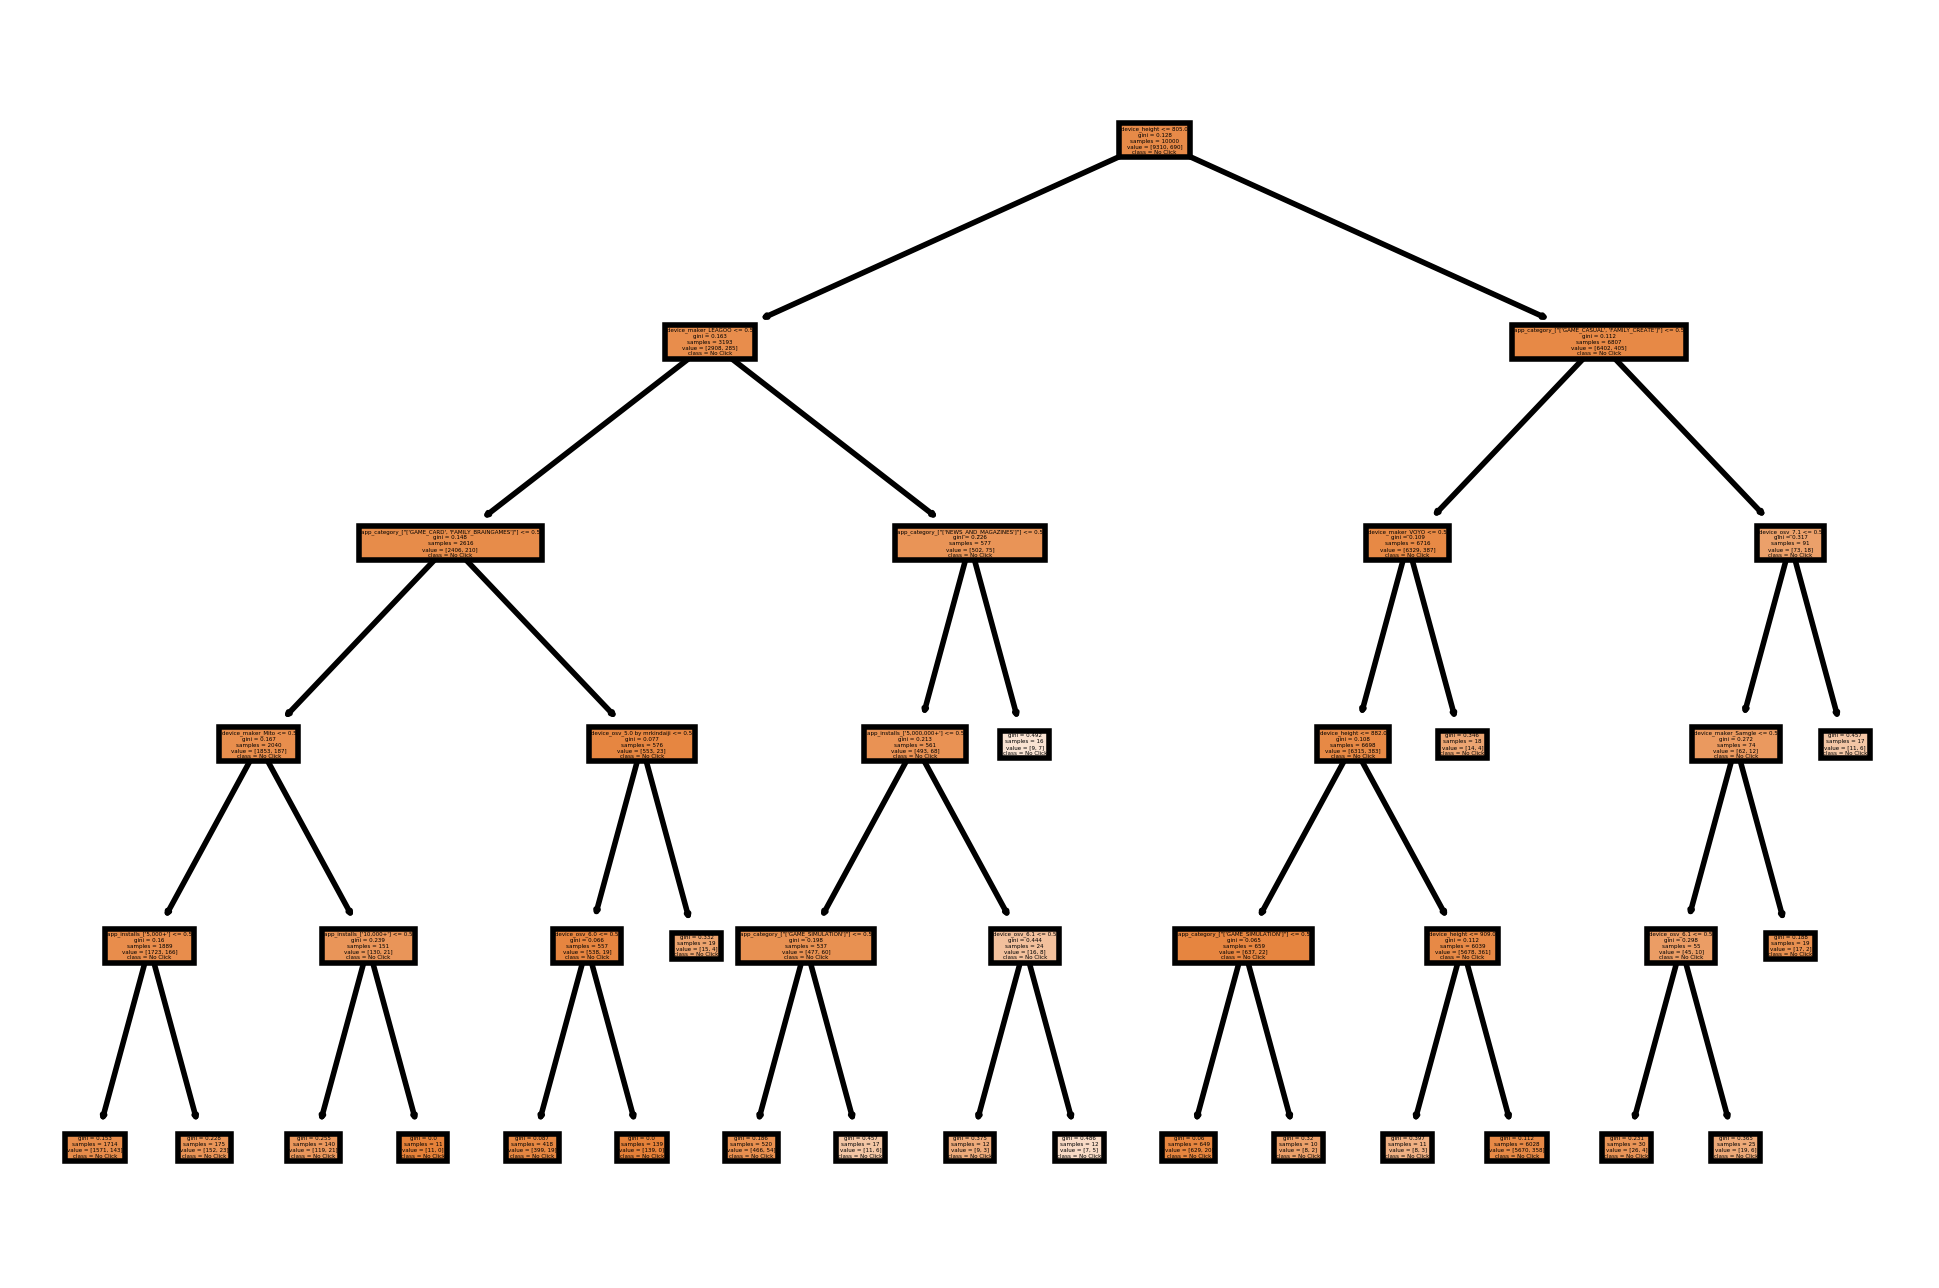

In [51]:
import matplotlib.pyplot as plt
from sklearn import tree
%matplotlib inline

feature_names = samples_for_dtc.columns
class_names =['No Click', 'Click']

fig, axes = plt.subplots(nrows=1, ncols=1, dpi=400)

tree.plot_tree(dtc_small, feature_names=feature_names, class_names= class_names, filled=True);

## Running GridSearchCV to find the best params for RandomForestClassifier 

In [73]:
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

oversampler = RandomOverSampler(sampling_strategy='minority')

print("Build train and test data ...")

samples_train = normelized_data_train.sample(10000)
samples_test = normelized_data_train.sample(10000)

# Real Data
# y_train_not_balance = normelized_data_train['click']
# x_train_not_balance = normelized_data_train.drop(['click'], axis=1)
# x_train, y_train = oversampler.fit_resample(x_train_not_balance, y_train_not_balance)

# y_test = normelized_data_test['click']
# x_test = normelized_data_test.drop(['click'], axis=1)

# Sample Data
y_train_not_balance = samples_train['click']
x_train_not_balance = samples_train.drop(['click'], axis=1)
x_train, y_train = oversampler.fit_resample(x_train_not_balance, y_train_not_balance)

y_test = samples_test['click']
x_test = samples_test.drop(['click'], axis=1)

print(f'Data size after balance {len(x_train)} and test {len(y_test)}')

print("Build train and test data ...END")

Build train and test data ...
Data size after balance 18724 and test 10000
Build train and test data ...END


In [56]:
from sklearn.model_selection import GridSearchCV 
from sklearn import datasets
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from pprint import pprint 


model_params = {
    'n_estimators': [4, 10, 50, 100, 204],
    'max_features': [1, 2, 3, 4],
    'min_samples_split': [2, 3, 5, 10]
}

# create random forest classifier model
print("Initialize the model ...")
rf_model = RandomForestClassifier()
print("Initialize the model ...END")

# set up random search meta-estimator
# this will train 10 models over 5 folds of cross validation (50 models total)

print("Initialize the GridSearchCV ...")
clf = GridSearchCV(rf_model, model_params, cv=5)

# train the random search meta-estimator to find the best model out of 10 candidates
print("Run the model ...")
model = clf.fit(x_train, y_train)
print("Run the model ...END")

# print winning set of hyperparameters
pprint(model.best_estimator_.get_params())

Initialize the model ...
Initialize the model ...END
Initialize the GridSearchCV ...
Run the model ...
Run the model ...END
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 2,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


## RandomForestClassifier with "best params"

In [57]:
from sklearn.ensemble import RandomForestClassifier

print('fmodel.best_params_ = {model.best_params_}')

print("Initialize the model ...")
rf = RandomForestClassifier(**model.best_params_)

print("Run the model ...")
rf.fit(x_train, y_train)
print("Run the model ...END")

# Check the model on the test data
print (f'\nRandomForestClassifier score : {rf.score(x_test, y_test)}')
print (f'\nRandomForestClassifier score(on the train data) : {rf.score(x_test, y_test)}')

print(f'Train Score: {rf.score(x_train, y_train)}\nTest Score: {rf.score(x_test, y_test)}')

y_pred = rf.predict(x_test)

print (f'\nconfusion_matrix:\n {confusion_matrix(y_test, y_pred)}')
print(f'\nclassification_report:\n {classification_report(y_test, y_pred)}')

fmodel.best_params_ = {model.best_params_}
Initialize the model ...
Run the model ...
Run the model ...END

RandomForestClassifier score : 0.882

RandomForestClassifier score(on the train data) : 0.882
Train Score: 0.9838536060279871
Test Score: 0.882

confusion_matrix:
 [[878  59]
 [ 59   4]]

classification_report:
               precision    recall  f1-score   support

           0       0.94      0.94      0.94       937
           1       0.06      0.06      0.06        63

    accuracy                           0.88      1000
   macro avg       0.50      0.50      0.50      1000
weighted avg       0.88      0.88      0.88      1000



## Running optuna to find the best params for RandomForestClassifier or SVC

In [74]:
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

oversampler = RandomOverSampler(sampling_strategy='minority')

print("Build train and test data ...")

samples_train = normelized_data_train.sample(10000)
samples_test = normelized_data_train.sample(10000)

# Real Data
# y_train_not_balance = normelized_data_train['click']
# x_train_not_balance = normelized_data_train.drop(['click'], axis=1)
# x_train, y_train = oversampler.fit_resample(x_train_not_balance, y_train_not_balance)

# y_test = normelized_data_test['click']
# x_test = normelized_data_test.drop(['click'], axis=1)

# Sample Data
y_train_not_balance = samples_train['click']
x_train_not_balance = samples_train.drop(['click'], axis=1)
x_train, y_train = oversampler.fit_resample(x_train_not_balance, y_train_not_balance)

y_test = samples_test['click']
x_test = samples_test.drop(['click'], axis=1)

print(f'Data size after balance {len(x_train)} and test {len(y_test)}')

print("Build train and test data ...END")

Build train and test data ...
Data size after balance 18538 and test 10000
Build train and test data ...END


In [75]:
# !pip install optuna -U

import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC

def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 2, 20)
    max_depth = trial.suggest_int('max_depth', 1, 32)
    clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth)
    
    return cross_val_score(clf, x_train, y_train, n_jobs=-1, cv=3).mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

trial = study.best_trial

print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

[I 2021-05-09 16:17:33,594] A new study created in memory with name: no-name-19e00e27-0a7f-4cc6-a924-bd1db8780012
[I 2021-05-09 16:17:33,981] Trial 0 finished with value: 0.7242959109333157 and parameters: {'n_estimators': 16, 'max_depth': 12}. Best is trial 0 with value: 0.7242959109333157.
[I 2021-05-09 16:17:34,311] Trial 1 finished with value: 0.6768252613988327 and parameters: {'n_estimators': 14, 'max_depth': 9}. Best is trial 0 with value: 0.7242959109333157.
[I 2021-05-09 16:17:34,762] Trial 2 finished with value: 0.7791024266519878 and parameters: {'n_estimators': 15, 'max_depth': 15}. Best is trial 2 with value: 0.7791024266519878.
[I 2021-05-09 16:17:35,387] Trial 3 finished with value: 0.8499836852141951 and parameters: {'n_estimators': 19, 'max_depth': 22}. Best is trial 3 with value: 0.8499836852141951.
[I 2021-05-09 16:17:35,997] Trial 4 finished with value: 0.8338546121262244 and parameters: {'n_estimators': 19, 'max_depth': 20}. Best is trial 3 with value: 0.8499836852

[I 2021-05-09 16:17:56,081] Trial 42 finished with value: 0.8615274654923514 and parameters: {'n_estimators': 16, 'max_depth': 29}. Best is trial 31 with value: 0.8696730740390993.
[I 2021-05-09 16:17:56,923] Trial 43 finished with value: 0.8681625640523379 and parameters: {'n_estimators': 18, 'max_depth': 30}. Best is trial 31 with value: 0.8696730740390993.
[I 2021-05-09 16:17:57,678] Trial 44 finished with value: 0.8684322337569242 and parameters: {'n_estimators': 18, 'max_depth': 30}. Best is trial 31 with value: 0.8696730740390993.
[I 2021-05-09 16:17:58,415] Trial 45 finished with value: 0.8636854079822512 and parameters: {'n_estimators': 20, 'max_depth': 26}. Best is trial 31 with value: 0.8696730740390993.
[I 2021-05-09 16:17:58,867] Trial 46 finished with value: 0.7709030727140139 and parameters: {'n_estimators': 16, 'max_depth': 15}. Best is trial 31 with value: 0.8696730740390993.
[I 2021-05-09 16:17:59,624] Trial 47 finished with value: 0.8640087881614537 and parameters: {'

[I 2021-05-09 16:18:27,849] Trial 85 finished with value: 0.8630917470577956 and parameters: {'n_estimators': 17, 'max_depth': 28}. Best is trial 75 with value: 0.871668828877712.
[I 2021-05-09 16:18:28,605] Trial 86 finished with value: 0.8651955338863077 and parameters: {'n_estimators': 18, 'max_depth': 29}. Best is trial 75 with value: 0.871668828877712.
[I 2021-05-09 16:18:29,443] Trial 87 finished with value: 0.8708596539100579 and parameters: {'n_estimators': 19, 'max_depth': 32}. Best is trial 75 with value: 0.871668828877712.
[I 2021-05-09 16:18:30,229] Trial 88 finished with value: 0.8685402395593664 and parameters: {'n_estimators': 19, 'max_depth': 32}. Best is trial 75 with value: 0.871668828877712.
[I 2021-05-09 16:18:30,727] Trial 89 finished with value: 0.8067213425855365 and parameters: {'n_estimators': 15, 'max_depth': 18}. Best is trial 75 with value: 0.871668828877712.
[I 2021-05-09 16:18:31,399] Trial 90 finished with value: 0.8647100620764944 and parameters: {'n_est

Accuracy: 0.871668828877712
Best hyperparameters: {'n_estimators': 17, 'max_depth': 32}


## RandomForestClassifier with "Best hyperparameters"

In [78]:
from sklearn.ensemble import RandomForestClassifier

print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

print("Initialize the model ...")
rf = RandomForestClassifier(**trial.params)

print("Run the model ...")
rf.fit(x_train, y_train)
print("Run the model ...END")

# Check the model on the test data
print (f'\nRandomForestClassifier score : {rf.score(x_test, y_test)}')
print (f'\nRandomForestClassifier score(on the train data) : {rf.score(x_test, y_test)}')

print(f'Train Score: {rf.score(x_train, y_train)}\nTest Score: {rf.score(x_test, y_test)}')

y_pred = rf.predict(x_test)

print (f'\nconfusion_matrix:\n {confusion_matrix(y_test, y_pred)}')
print(f'\nclassification_report:\n {classification_report(y_test, y_pred)}')

Accuracy: 0.871668828877712
Best hyperparameters: {'n_estimators': 17, 'max_depth': 32}
Initialize the model ...
Run the model ...
Run the model ...END

RandomForestClassifier score : 0.7847

RandomForestClassifier score(on the train data) : 0.7847
Train Score: 0.892598985866868
Test Score: 0.7847

confusion_matrix:
 [[7687 1609]
 [ 544  160]]

classification_report:
               precision    recall  f1-score   support

           0       0.93      0.83      0.88      9296
           1       0.09      0.23      0.13       704

    accuracy                           0.78     10000
   macro avg       0.51      0.53      0.50     10000
weighted avg       0.87      0.78      0.82     10000



# KNN

In [79]:
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

oversampler = RandomOverSampler(sampling_strategy='minority')

print("Build train and test data ...")

samples_train = normelized_data_train.sample(10000)
samples_test = normelized_data_train.sample(10000)

# Real Data
# y_train_not_balance = normelized_data_train['click']
# x_train_not_balance = normelized_data_train.drop(['click'], axis=1)
# x_train, y_train = oversampler.fit_resample(x_train_not_balance, y_train_not_balance)

# y_test = normelized_data_test['click']
# x_test = normelized_data_test.drop(['click'], axis=1)

# Sample Data
y_train_not_balance = samples_train['click']
x_train_not_balance = samples_train.drop(['click'], axis=1)
x_train, y_train = oversampler.fit_resample(x_train_not_balance, y_train_not_balance)

y_test = samples_test['click']
x_test = samples_test.drop(['click'], axis=1)

print(f'Data size after balance {len(x_train)} and test {len(y_test)}')

print("Build train and test data ...END")

Build train and test data ...
Data size after balance 1864 and test 1000
Build train and test data ...END


In [66]:
from sklearn.neighbors import KNeighborsClassifier
import numpy as np

print("Prepering the Model ...")
k = int(np.sqrt(len(x_train)))
knn = KNeighborsClassifier(n_neighbors=k)

print("Run the Model ...")
knn.fit(x_train, y_train)

print("Run the Model Done, building the score")
print(f'knn.score on the train = {knn.score(x_train, y_train)}')
print(f'knn.score on the test = {knn.score(x_test, y_test)}')    

errors = []
for k in range(1,10):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_train, y_train)
    errors.append(1 - knn.score(x_test, y_test))
    print(f'round number {k}')
    
print("Done")

Prepering the Model ...
Run the Model ...
Run the Model Done, building the score
knn.score on the train = 0.7267932489451476
knn.score on the test = 0.563
round number 1
round number 2
round number 3
round number 4
round number 5
round number 6
round number 7
round number 8
round number 9
Done


In [80]:
# Check the model on the test data
print (f'\nRandomForestClassifier score : {knn.score(x_test, y_test)}')
print (f'\nRandomForestClassifier score(on the train data) : {knn.score(x_test, y_test)}')

print(f'Train Score: {knn.score(x_train, y_train)}\nTest Score: {knn.score(x_test, y_test)}')

y_pred = rf.predict(x_test)

print (f'\nconfusion_matrix:\n {confusion_matrix(y_test, y_pred)}')
print(f'\nclassification_report:\n {classification_report(y_test, y_pred)}')


RandomForestClassifier score : 0.741

RandomForestClassifier score(on the train data) : 0.741
Train Score: 0.5547210300429185
Test Score: 0.741

confusion_matrix:
 [[769 159]
 [ 53  19]]

classification_report:
               precision    recall  f1-score   support

           0       0.94      0.83      0.88       928
           1       0.11      0.26      0.15        72

    accuracy                           0.79      1000
   macro avg       0.52      0.55      0.52      1000
weighted avg       0.88      0.79      0.83      1000



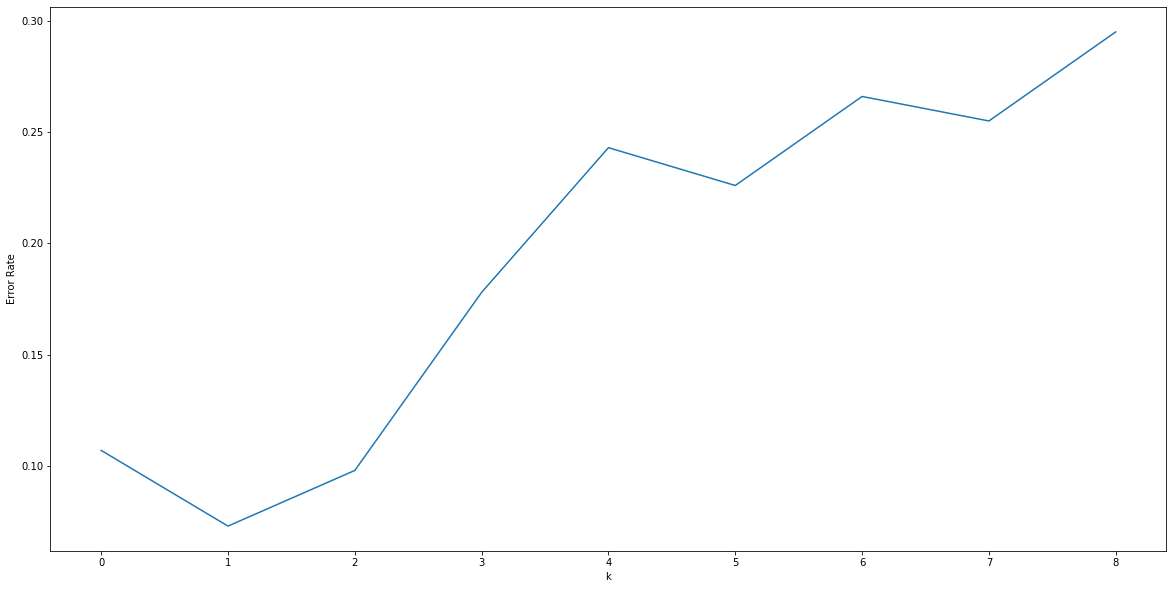

Done


In [81]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(20,10))
ax = fig.gca()
ax.set_ylabel('Error Rate')
ax.set_xlabel('k')

ax.plot(errors)
plt.show()

print("Done")

# SGDClassifier

In [82]:
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

oversampler = RandomOverSampler(sampling_strategy='minority')

print("Build train and test data ...")

samples_train = normelized_data_train.sample(10000)
samples_test = normelized_data_train.sample(10000)

# Real Data
# y_train_not_balance = normelized_data_train['click']
# x_train_not_balance = normelized_data_train.drop(['click'], axis=1)
# x_train, y_train = oversampler.fit_resample(x_train_not_balance, y_train_not_balance)

# y_test = normelized_data_test['click']
# x_test = normelized_data_test.drop(['click'], axis=1)

# Sample Data
y_train_not_balance = samples_train['click']
x_train_not_balance = samples_train.drop(['click'], axis=1)
x_train, y_train = oversampler.fit_resample(x_train_not_balance, y_train_not_balance)

y_test = samples_test['click']
x_test = samples_test.drop(['click'], axis=1)

print(f'Data size after balance {len(x_train)} and test {len(y_test)}')

print("Build train and test data ...END")

Build train and test data ...
Data size after balance 18732 and test 10000
Build train and test data ...END


In [83]:
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X = x_train
y = y_train

scaler = StandardScaler()
scaler.fit(X)

X_scaled = scaler.transform(X)
x_train, x_test, y_train, y_test = train_test_split(X_scaled, y, train_size=0.85)

# If not specifically stated, SGDClassifier uses SVM by default
clf = SGDClassifier(max_iter=1000, tol=1e-3) 

print("Run the model ...")
clf.fit(x_train, y_train)

print("calculate the score ...")
clf.score(x_test, y_test)

Run the model ...
calculate the score ...


0.5779359430604982

In [41]:
# Check the model on the test data
print (f'\nRandomForestClassifier score : {clf.score(x_test, y_test)}')
print (f'\nRandomForestClassifier score(on the train data) : {clf.score(x_test, y_test)}')

print(f'Train Score: {clf.score(x_train, y_train)}\nTest Score: {clf.score(x_test, y_test)}')

y_pred = rf.predict(x_test)

print (f'\nconfusion_matrix:\n {confusion_matrix(y_test, y_pred)}')
print(f'\nclassification_report:\n {classification_report(y_test, y_pred)}')


RandomForestClassifier score : 0.6062992125984252

RandomForestClassifier score(on the train data) : 0.6062992125984252
Train Score: 0.6065066329753632
Test Score: 0.6062992125984252

confusion_matrix:
 [[1364   35]
 [1357   38]]

classification_report:
               precision    recall  f1-score   support

           0       0.50      0.97      0.66      1399
           1       0.52      0.03      0.05      1395

    accuracy                           0.50      2794
   macro avg       0.51      0.50      0.36      2794
weighted avg       0.51      0.50      0.36      2794



# GradientBoostingClassifier

In [85]:
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

oversampler = RandomOverSampler(sampling_strategy='minority')

print("Build train and test data ...")

samples_train = normelized_data_train.sample(10000)
samples_test = normelized_data_train.sample(10000)

# Real Data
# y_train_not_balance = normelized_data_train['click']
# x_train_not_balance = normelized_data_train.drop(['click'], axis=1)
# x_train, y_train = oversampler.fit_resample(x_train_not_balance, y_train_not_balance)

# y_test = normelized_data_test['click']
# x_test = normelized_data_test.drop(['click'], axis=1)

# Sample Data
y_train_not_balance = samples_train['click']
x_train_not_balance = samples_train.drop(['click'], axis=1)
x_train, y_train = oversampler.fit_resample(x_train_not_balance, y_train_not_balance)

y_test = samples_test['click']
x_test = samples_test.drop(['click'], axis=1)

print(f'Data size after balance {len(x_train)} and test {len(y_test)}')

print("Build train and test data ...END")

Build train and test data ...
Data size after balance 18720 and test 10000
Build train and test data ...END


In [86]:
from sklearn.ensemble import GradientBoostingClassifier
from tqdm import tqdm

lr_list = [0.1, 0.2, 0.4, 0.8, 1]
mf_list = [2, 4, 8, 16, 32, 64, 258]

best_score = 0

for max_f in tqdm(mf_list):
    for learnning_rate in  lr_list:
        gb_clf = GradientBoostingClassifier(n_estimators=200, learning_rate=learnning_rate, max_features=max_f, max_depth=2)
        gb_clf.fit(x_train, y_train)
        
        train_score = gb_clf.score(x_train, y_train)
        test_score = gb_clf.score(x_test, y_test)
        print(f'Train score = {train_score}, Test score = {test_score}')
        
        if(best_score < train_score):
            best_score = train_score
            
print(f'Best Score: {best_score}')   

  0%|                                                                                            | 0/7 [00:00<?, ?it/s]

Train score = 0.6373931623931623, Test score = 0.6143
Train score = 0.6431089743589744, Test score = 0.6116
Train score = 0.6397435897435897, Test score = 0.627
Train score = 0.6634615384615384, Test score = 0.637


 14%|████████████                                                                        | 1/7 [00:02<00:15,  2.59s/it]

Train score = 0.6527777777777778, Test score = 0.6255
Train score = 0.638301282051282, Test score = 0.6372
Train score = 0.6349893162393162, Test score = 0.6124
Train score = 0.6465811965811966, Test score = 0.6244
Train score = 0.6504807692307693, Test score = 0.6262


 29%|████████████████████████                                                            | 2/7 [00:05<00:13,  2.63s/it]

Train score = 0.6530982905982906, Test score = 0.6221
Train score = 0.6409722222222223, Test score = 0.6204
Train score = 0.6399572649572649, Test score = 0.6272
Train score = 0.6475427350427351, Test score = 0.6288
Train score = 0.6683760683760683, Test score = 0.6355


 43%|████████████████████████████████████                                                | 3/7 [00:08<00:11,  2.78s/it]

Train score = 0.6646901709401709, Test score = 0.6265
Train score = 0.6377136752136752, Test score = 0.6305
Train score = 0.6493055555555556, Test score = 0.6371
Train score = 0.652190170940171, Test score = 0.6327
Train score = 0.6665064102564102, Test score = 0.6244


 57%|████████████████████████████████████████████████                                    | 4/7 [00:12<00:09,  3.13s/it]

Train score = 0.673931623931624, Test score = 0.6356
Train score = 0.6409188034188035, Test score = 0.637
Train score = 0.6531517094017094, Test score = 0.6406
Train score = 0.6625534188034188, Test score = 0.6391
Train score = 0.6894230769230769, Test score = 0.6348


 71%|████████████████████████████████████████████████████████████                        | 5/7 [00:18<00:07,  3.93s/it]

Train score = 0.688034188034188, Test score = 0.6458
Train score = 0.6493055555555556, Test score = 0.649
Train score = 0.6568910256410256, Test score = 0.6313
Train score = 0.6709401709401709, Test score = 0.6374
Train score = 0.6933226495726496, Test score = 0.6379


 86%|████████████████████████████████████████████████████████████████████████            | 6/7 [00:27<00:05,  5.47s/it]

Train score = 0.7121260683760684, Test score = 0.6489
Train score = 0.6547542735042735, Test score = 0.6473
Train score = 0.6726495726495727, Test score = 0.6467
Train score = 0.6995192307692307, Test score = 0.6584
Train score = 0.7276175213675213, Test score = 0.669


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:52<00:00,  7.55s/it]

Train score = 0.7448717948717949, Test score = 0.6769
Best Score: 0.7448717948717949


<div style="line-height:1.75;background:#3464a2;padding-left:20px;padding-top:5px;padding-bottom:5px;border-radius:5px 5px 0px 0px">
<i style="font-size:40px;color:#e6f1ff;">Phase 5:Conclusion</i>
</div>
<div>
<p style="line-height:1.75;background:#e6f1ff;padding:20px;border-radius:0px 0px 5px 5px">
Please see the resoults below:<br>
I focus on the score since fist my data is balanced and second i can use it to compare the result with all models<br><br>  
<strong>DecisionTreeClassifier</strong>(criterion='gini', max_depth=5, min_samples_split=10, min_samples_leaf=10)<br>
score : 0.573<br>
<strong>RandomForestClassifier</strong> with "best params"<br>
score : 0.497<br>
<strong>RandomForestClassifier</strong> with "Best hyperparameters"<br>
score : 0.7847<br>
<strong>KNN</strong><br>
score : 0.741<br>
<strong>SGDClassifier</strong><br>
score : 0.606<br>
<strong>GradientBoostingClassifier</strong><br>
score : 0.744<br><br>
<strong>Conclusion: need a better computer or find a way to run on the GPU :-)</strong>
</p></div>